In [ ]:
import pandas as pd
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split


In [ ]:
#Make 1000 samples of multi-class data
n_samples = 1000
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42
# Create circles
X_blob, y_blob = make_blobs(n_samples,
                            n_features=NUM_FEATURES, #X features
                            centers =NUM_CLASSES, # y labels
                            cluster_std= 1.5,
                            random_state=RANDOM_SEED) # Keep random state so we get the same values

In [ ]:
print (f"First 5 X features:\n{X_blob[:5]}")
print(f"First 5 y labels:\n{y_blob[:5]}")

First 5 X features:
[[-8.41339595  6.93516545]
 [-5.76648413 -6.43117072]
 [-6.04213682 -6.76610151]
 [ 3.95083749  0.69840313]
 [ 4.25049181 -0.28154475]]
First 5 y labels:
[3 2 2 1 1]


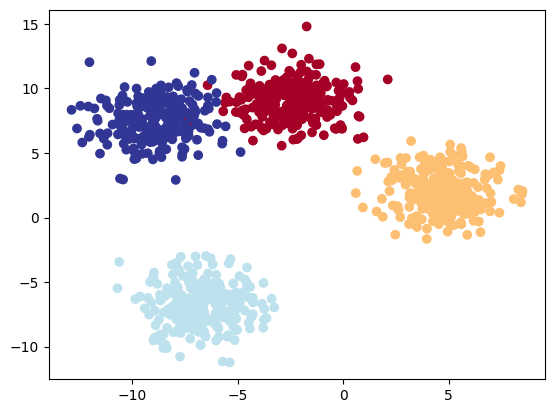

In [ ]:
#visualize with a plot
import matplotlib.pyplot as plt
plt.scatter(x=X_blob[:,0],
            y=X_blob[:, 1],
            c=y_blob,
            cmap=plt.cm.RdYlBu);

#####Turning data into tensors

In [ ]:
X_blob.dtype

dtype('float64')

In [ ]:
import torch

X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)


#view the first five samples
X_blob[:5], y_blob[:5]

(tensor([[-8.4134,  6.9352],
         [-5.7665, -6.4312],
         [-6.0421, -6.7661],
         [ 3.9508,  0.6984],
         [ 4.2505, -0.2815]]),
 tensor([3, 2, 2, 1, 1]))

##### Split into train and test sets

In [ ]:
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob,
    y_blob,
    test_size=0.2,
    random_state=RANDOM_SEED
)

###Building a multi-class classsification model in PyTorch

In [ ]:
import torch
# Make device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
from torch import nn

# Build model
class BlobModel(nn.Module):
    def __init__(self, input_features, output_features, hidden_units=8):
        """Initializes all required hyperparameters for a multi-class classification model.

        Args:
            input_features (int): Number of input features to the model.
            out_features (int): Number of output features of the model
              (how many classes there are).
            hidden_units (int): Number of hidden units between layers, default 8.
        """
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidden_units),
            # nn.ReLU(), # <- does our dataset require non-linear layers? (try uncommenting and see if the results change)
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            # nn.ReLU(), # <- does our dataset require non-linear layers? (try uncommenting and see if the results change)
            nn.Linear(in_features=hidden_units, out_features=output_features), # how many classes are there?
        )

    def forward(self, x):
        return self.linear_layer_stack(x)

# Create an instance of BlobModel and send it to the target device
model_4 = BlobModel(input_features=NUM_FEATURES,
                    output_features=NUM_CLASSES,
                    hidden_units=8).to(device)
model_4

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): Linear(in_features=8, out_features=8, bias=True)
    (2): Linear(in_features=8, out_features=4, bias=True)
  )
)

####Creating a loss function and optimizer for a multi-class PyTorch model

In [ ]:
# Create loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_4.parameters(),
                            lr=0.1)

#### Getting prediction probabilities for a multi-class PyTorch model

In [ ]:
# Perform a single forward pass on the data (we'll need to put it to the target device for it to work)
model_4(X_blob_train.to(device))[:5]

tensor([[-0.3598,  0.5374,  0.8903, -0.0607],
        [-2.3680,  1.2185,  2.6825,  0.3565],
        [ 0.6948, -1.3899, -1.2343,  0.1352],
        [ 0.0410, -0.7226, -0.3149,  0.1532],
        [-1.9853,  0.8945,  2.1945,  0.3283]], device='cuda:0',
       grad_fn=<SliceBackward0>)

In [ ]:
# How many elements in a single prediction sample?
model_4(X_blob_train.to(device))[0].shape, NUM_CLASSES

(torch.Size([4]), 4)

In [ ]:
# Make prediction logits with model
y_logits = model_4(X_blob_test.to(device))

# Perform softmax calculation on logits across dimension 1 to get prediction probabilities
y_pred_probs = torch.softmax(y_logits, dim=1)
print(y_logits[:5])
print(y_pred_probs[:5])

tensor([[-0.6308,  0.6883,  1.1765, -0.0200],
        [-2.3933,  0.7563,  2.3501,  0.4862],
        [ 0.6900, -1.1863, -1.0778,  0.0828],
        [-0.0776,  0.2245,  0.4746, -0.0619],
        [-2.2411,  1.3539,  2.7037,  0.2830]], device='cuda:0',
       grad_fn=<SliceBackward0>)
tensor([[0.0789, 0.2950, 0.4808, 0.1453],
        [0.0064, 0.1486, 0.7316, 0.1135],
        [0.5351, 0.0820, 0.0913, 0.2916],
        [0.1959, 0.2649, 0.3402, 0.1990],
        [0.0053, 0.1913, 0.7379, 0.0656]], device='cuda:0',
       grad_fn=<SliceBackward0>)


In [ ]:
# Sum the first sample output of the softmax activation function
torch.sum(y_pred_probs[0])

tensor(1.0000, device='cuda:0', grad_fn=<SumBackward0>)

In [ ]:
# Which class does the model think is *most* likely at the index 0 sample?
print(y_pred_probs[0])
print(torch.argmax(y_pred_probs[0]))

tensor([0.0789, 0.2950, 0.4808, 0.1453], device='cuda:0',
       grad_fn=<SelectBackward0>)
tensor(2, device='cuda:0')


####Creating a training and testing loop for a multi-class PyTorch model

In [ ]:
# Calculate accuracy (a classification metric)
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100
    return acc

In [ ]:
# Fit the model
torch.manual_seed(42)

# Set number of epochs
epochs = 100

# Put data to target device
X_blob_train, y_blob_train = X_blob_train.to(device), y_blob_train.to(device)
X_blob_test, y_blob_test = X_blob_test.to(device), y_blob_test.to(device)

for epoch in range(epochs):
    ### Training
    model_4.train()

    # 1. Forward pass
    y_logits = model_4(X_blob_train) # model outputs raw logits
    y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1) # go from logits -> prediction probabilities -> prediction labels
    # print(y_logits)
    # 2. Calculate loss and accuracy
    loss = loss_fn(y_logits, y_blob_train)
    acc = accuracy_fn(y_true=y_blob_train,
                      y_pred=y_pred)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_4.eval()
    with torch.inference_mode():
      # 1. Forward pass
      test_logits = model_4(X_blob_test)
      test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)
      # 2. Calculate test loss and accuracy
      test_loss = loss_fn(test_logits, y_blob_test)
      test_acc = accuracy_fn(y_true=y_blob_test,
                             y_pred=test_pred)

    # Print out what's happening
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 2.70071, Acc: 0.38% | Test Loss: 0.77772, Test Acc: 75.00%
Epoch: 10 | Loss: 0.18053, Acc: 99.00% | Test Loss: 0.16039, Test Acc: 99.00%
Epoch: 20 | Loss: 0.09546, Acc: 99.00% | Test Loss: 0.08709, Test Acc: 99.50%
Epoch: 30 | Loss: 0.06837, Acc: 99.00% | Test Loss: 0.06098, Test Acc: 99.50%
Epoch: 40 | Loss: 0.05564, Acc: 99.00% | Test Loss: 0.04819, Test Acc: 99.50%
Epoch: 50 | Loss: 0.04842, Acc: 99.00% | Test Loss: 0.04074, Test Acc: 99.50%
Epoch: 60 | Loss: 0.04382, Acc: 99.00% | Test Loss: 0.03591, Test Acc: 99.50%
Epoch: 70 | Loss: 0.04068, Acc: 99.00% | Test Loss: 0.03254, Test Acc: 99.50%
Epoch: 80 | Loss: 0.03841, Acc: 99.00% | Test Loss: 0.03007, Test Acc: 99.50%
Epoch: 90 | Loss: 0.03670, Acc: 99.00% | Test Loss: 0.02817, Test Acc: 99.50%


In [ ]:
# Make predictions
model_4.eval()
with torch.inference_mode():
    y_logits = model_4(X_blob_test)

# View the first 10 predictions
y_logits[:10]

tensor([[  5.9517,  11.3784, -10.6432,  -6.6569],
        [  2.5982, -12.8391,   1.1438,   8.3132],
        [-10.7285, -16.5345,  18.2196,   9.9365],
        [  2.3473,   7.8031,  -5.1963,  -4.6072],
        [  9.2389,   4.4937, -12.3476,  -2.1824],
        [  2.7565, -15.8886,   1.9358,  10.2282],
        [-10.6141, -13.1859,  17.0062,   7.8486],
        [  7.2508,  -0.1274,  -8.4913,   0.6046],
        [-11.7153, -22.2520,  21.2350,  13.4608],
        [  7.8222,   1.5339,  -9.7068,  -0.4047]], device='cuda:0')

In [ ]:
# Turn predicted logits in prediction probabilities
y_pred_probs = torch.softmax(y_logits, dim=1)

# Turn prediction probabilities into prediction labels
y_preds = y_pred_probs.argmax(dim=1)

# Compare first 10 model preds and test labels
print(f"Predictions: {y_preds[:10]}\nLabels: {y_blob_test[:10]}")
print(f"Test accuracy: {accuracy_fn(y_true=y_blob_test, y_pred=y_preds)}%")

Predictions: tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0], device='cuda:0')
Labels: tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0], device='cuda:0')
Test accuracy: 99.5%


In [ ]:
# Create helper_functions.py if it doesn't exist
# You would need to fill in the actual implementations of these functions
# This is a placeholder to resolve the import error

"""
Helper functions for PyTorch model training and evaluation.
"""

def plot_predictions(train_data, train_labels, test_data, test_labels, predictions=None):
    """
    Plots training data, testing data and compares predictions.
    """
    plt.figure(figsize=(10, 7))
    plt.scatter(train_data[:, 0], train_data[:, 1], c=train_labels, s=40, cmap=plt.cm.RdYlBu, label="Train data")
    plt.scatter(test_data[:, 0], test_data[:, 1], c=test_labels, s=40, cmap=plt.cm.RdYlBu, label="Test data")
    if predictions is not None:
        plt.scatter(test_data[:, 0], test_data[:, 1], c=predictions, s=40, cmap=plt.cm.RdYlBu, marker='x', label="Predictions")
    plt.legend(loc="best")
    plt.title("Train, Test and Prediction Data")
    plt.show()

def plot_decision_boundary(model, X, y):
    """Plots decision boundaries of model predicting on X in comparison to y.
    Source: https://madewithml.com/courses/basics/plotting-decision-boundaries/
     & https://github.com/pytorch/tutorials/blob/main/beginner_source/basics/quickstart_tutorial.py
    """
    # Put everything to CPU (works better with NumPy + Matplotlib)
    model.to("cpu")
    X, y = X.to("cpu"), y.to("cpu")

    # 0. Setup prediction boundaries and make grid of 100x100 points
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                         np.linspace(y_min, y_max, 100))

    # 1. Make features
    X_to_pred_on = torch.from_numpy(np.vstack((xx.ravel(), yy.ravel())).T).float()

    # 2. Make predictions
    model.eval()
    with torch.inference_mode():
        y_logits = model(X_to_pred_on)

    # Test for multi-class or binary and adjust accordingly
    if len(torch.unique(y)) > 2:
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)  # mutli-class
    else:
        y_pred = torch.round(torch.sigmoid(y_logits)) # binary

    # 3. Plot training examples and decision boundary
    y_pred = y_pred.reshape(xx.shape).detach().numpy()
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

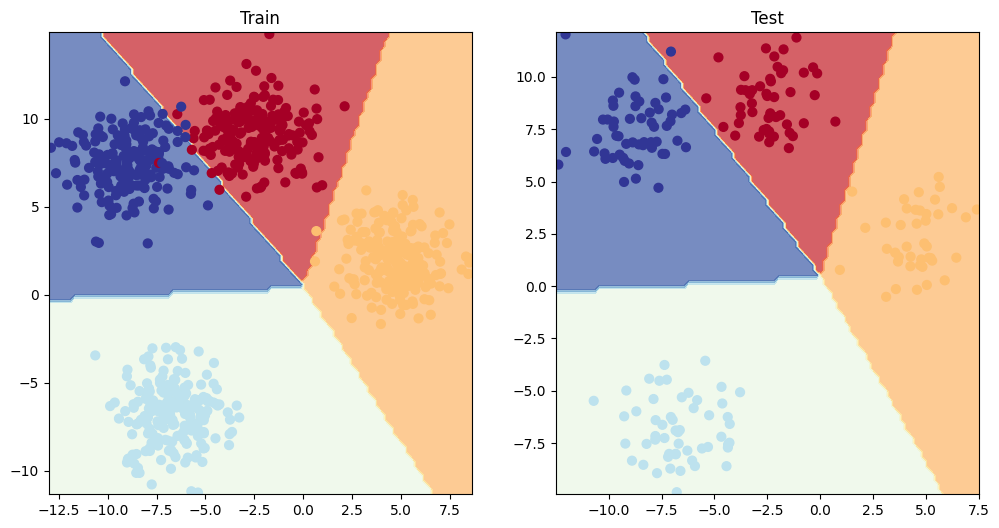

In [ ]:
import numpy as np

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_4, X_blob_train, y_blob_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_4, X_blob_test, y_blob_test)

In [ ]:
try:
    from torchmetrics import Accuracy
except:
    !pip install torchmetrics==0.9.3 # this is the version we're using in this notebook (later versions exist here: https://torchmetrics.readthedocs.io/en/stable/generated/CHANGELOG.html#changelog)
    from torchmetrics import Accuracy

# Setup metric and make sure it's on the target device
torchmetrics_accuracy = Accuracy(task='multiclass', num_classes=4).to(device)

# Calculate accuracy
torchmetrics_accuracy(y_preds, y_blob_test)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 419.6/419.6 kB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 109.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 91.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 57.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 20.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 86.9 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstal

tensor(0.9950, device='cuda:0')